### Note

The Google Colab free tier terminates the instance after 90 minutes of idle time. You can keep the instance running for up to 12 hours by periodically making changes to the notebook. After termination, any stored files will be removed. To protect any files that you would like to keep, please download them to your computer.

Stored files can be found in the "Files" menu on the left toolbar:

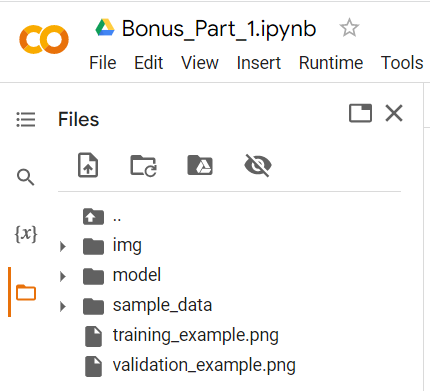

Last edited: 4/19/2022

## Visualize
Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to visualize some examples from the MNIST dataset of handwritten digits

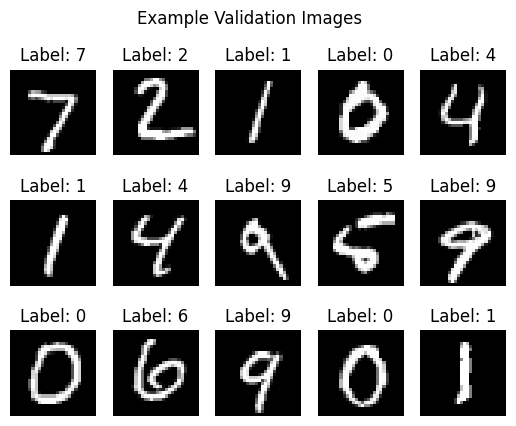

In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

train, val = mnist.load_data()
nrow, ncol = 3, 5

for data, label, kind in [(*train, 'Training'), (*val, 'Validation')]:
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            plt.subplot(nrow, ncol, idx + 1)
            plt.imshow(data[idx], cmap='gray')
            plt.title('Label: %d' % label[idx])
            plt.axis('off')

    plt.suptitle('Example %s Images' % kind)
    plt.savefig('%s_example.png' % kind.lower())
    plt.show()

## Parameters

In [37]:
FILE_PREFIX = 'dense_arch1'   # The model is saved in a file with the provided prefix under the folder icon on the left
DENSE_NET = False              # True trains a dense NN, False trains a convolutional NN
REGULARIZATION = 0.00         # l2 regularization strength

## Train
Author: Aadyot Bhatnagar

Last modified: April 19, 2022

Description: A script to train and save a neural net to recognize the MNIST dataset of handwritten digits. Supports both a standard dense network and a convolutional network.

In [41]:
import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.regularizers import l1, l2, L1L2
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

## Return MNIST dataset, shaped appropriately depending on whether we are
## want to train a dense or convolutional neural net
def get_data(is_net_conv):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize input images to have all values in [0, 1]
    # Reshape image dataset to have shape (N, H, W, C) instead of (N, H, W)
    if is_net_conv:
        X_train = X_train.reshape((*(X_train.shape), 1)) / 255
        X_test = X_test.reshape((*(X_test.shape), 1)) / 255

    # Normalize input images to have all values in [0, 1]
    # Flatten image dataset to have shape (N, H * W) instead of (N, H, W)
    else:
        X_train = X_train.reshape((X_train.shape[0], -1)) / 255
        X_test = X_test.reshape((X_test.shape[0], -1)) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


## Construct a dense neural net and return it
def build_dense_net(reg_param):
    model = Sequential()
    model.add(Dense(200, input_shape=(784,), kernel_regularizer=l1(reg_param)))
    model.add(Activation('relu'))
    model.add(Dense(100, kernel_regularizer=l1(reg_param)))
    model.add(Activation('relu'))
    model.add(Dense(10, kernel_regularizer=l1(reg_param)))
    model.add(Activation('softmax'))
    return model


## Construct a convolutional neural net and return it
def build_conv_net(reg_param):
    model = Sequential()
    model.add(Conv2D(200, (5, 5), padding='same',
                     input_shape=(28, 28, 1),
                     kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(100, (3, 3), padding='same',
        kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Need to flatten tensor output from conv layer to vector for dense layer
    model.add(Flatten())
    model.add(Dense(10, kernel_regularizer=l2(reg_param)))
    model.add(Activation('softmax'))

    return model


def main(file_prefix, dense_net=True, regularization=0.00):
    """
    Trains a NN to recognize handwritten digits.

    file_prefix - prefix for file to save trained model to (e.g. dense_arch1, conv_regularize05, etc.)
    dense_net - whether to train a dense NN or a convolutional NN (defaults to dense NN)
    regularization - strength of l2 regularization to use (defaults to no regularization)
    """
    model_name = file_prefix

    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)
    plot_fname = os.path.join(cwd, 'img', '%s_learn.png' % model_name)

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', model_name + '.h5')
    model_json_fname = os.path.join(cwd, 'model', model_name + '.json')

    is_net_conv = not dense_net
    regularizer_strength = regularization

    # Importing the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = get_data(is_net_conv)

    if is_net_conv:
        model = build_conv_net(regularizer_strength)
    else:
        model = build_dense_net(regularizer_strength)

    # Print a summary of the layers and weights in the model
    model.summary()

    # Have our model minimize the categorical cross entropy loss with the adam
    # optimizer (fancier stochastic gradient descent that converges faster)
    model.compile(loss='categorical_crossentropy', optimizer='adam',
        metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, 
        validation_data=(X_test, y_test))

    # Save model weights and json spec describing the model's architecture
    model.save(model_weights_fname)
    model_json = model.to_json()
    with open(model_json_fname, 'w') as f:
        f.write(json.dumps(json.loads(model_json), indent=4))

    # Plot accuracy learning curve
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('%s accuracy' % model_name)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.savefig(plot_fname)

    # Plot loss learning curve
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s loss' % model_name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(plot_fname)
    plt.show()
    
main(FILE_PREFIX, DENSE_NET, REGULARIZATION)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 200)       5200      
                                                                 
 activation_67 (Activation)  (None, 28, 28, 200)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 200)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 100)       180100    
                                                                 
 activation_68 (Activation)  (None, 14, 14, 100)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 100)        0         
 2D)                                                 

KeyboardInterrupt: 

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 200)               157000    
                                                                 
 activation_70 (Activation)  (None, 200)               0         
                                                                 
 dense_67 (Dense)            (None, 100)               20100     
                                                                 
 activation_71 (Activation)  (None, 100)               0         
                                                                 
 dense_68 (Dense)            (None, 10)                1010      
                                                                 
 activation_72 (Activation)  (None, 10)                0         
                                                                 
Total params: 178,110
Trainable params: 178,110
Non-t

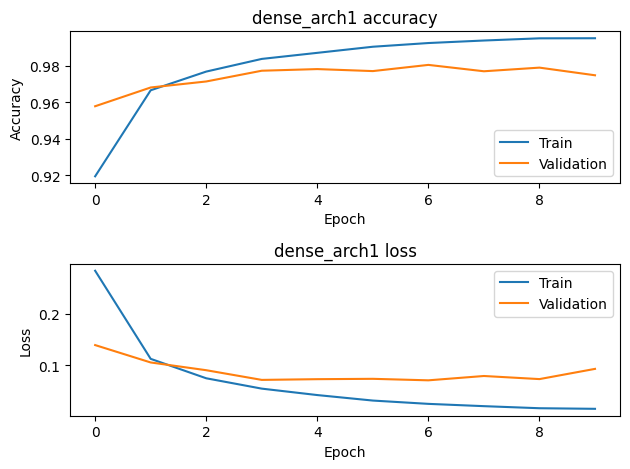

In [42]:
main(FILE_PREFIX, True, REGULARIZATION)

## Evaluate

Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to load and evaluate a saved Keras model's performance on the MNIST dataset of handwritten images. Prints out training and validation loss and accuracy, and also visualizes validation images the model got wrong.

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.datasets import mnist
from keras.utils import np_utils

## Get data in a format compatible with the neural net we want to evaluate
def get_data(model):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Determine input shape that the model given should take
    input_shape = model.get_layer(index=0).input_shape

    # Normalize data to be in [0, 1] and reshape appropriately
    X_train = X_train.reshape(-1, *input_shape[1:]) / 255
    X_test = X_test.reshape(-1, *input_shape[1:]) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


def main(file_prefix):
    model_name = file_prefix

    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', model_name + '.h5')
    model_json_fname = os.path.join(cwd, 'model', model_name + '.json')

    # Load model and its weights
    with open(model_json_fname, 'r') as f: model_json = f.read()
    model = model_from_json(model_json)
    model.load_weights(model_weights_fname)

    # Get MNIST data shaped appropriately for the model
    (X_train, y_train), (X_test, y_test) = get_data(model)

    # Compile model and evaluate its performance on training and test data
    model.compile(loss='categorical_crossentropy', optimizer='adam',
        metrics=['accuracy'])

    score = model.evaluate(X_train, y_train, verbose=0)
    print()
    print('Training loss:', score[0])
    print('Training accuracy:', score[1])

    score = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

    # Determine validation examples that the model got wrong
    y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
    y_true = np.array([np.argmax(y) for y in y_test])
    mistakes = (y_pred != y_true)
    X_wrong = X_test[mistakes].reshape(-1, 28, 28) # To visualize properly
    y_wrong = y_pred[mistakes]
    y_right = y_true[mistakes]

    # Visualize some of the validation examples the model got wrong
    nrow, ncol = 3, 5
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            ax = axs[i][j]
            ax.imshow(X_wrong[idx], cmap='gray')
            ax.set_title('Pred: %d\nTrue: %d' % (y_wrong[idx], y_right[idx]))
            ax.axis('off')
    
    fig.tight_layout(pad=2.5)

    plt.suptitle('Validation Images %s Got Wrong' % model_name)
    plt.savefig(os.path.join(cwd, 'img', '%s_mistakes.png') % model_name)
    plt.show()


Training loss: 0.004533630795776844
Training accuracy: 0.9986333250999451

Validation loss: 0.03143271058797836
Validation accuracy: 0.991100013256073
313/313 [==============================] - 5s 15ms/step


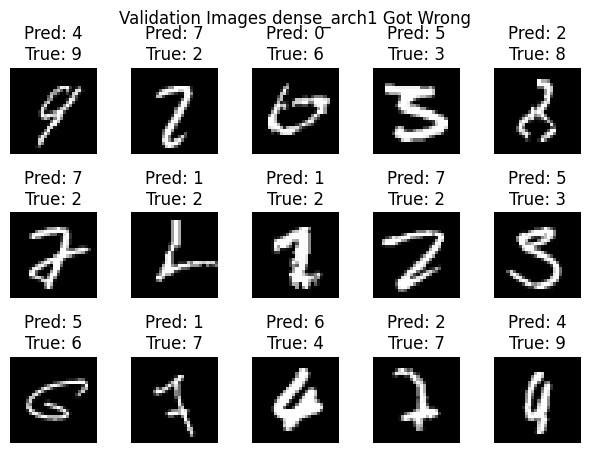

In [40]:
main(FILE_PREFIX)